In [1]:
import pennylane as qml
from pennylane import numpy as np

# let us define our operator W

class W(qml.operation.Operation):
    
    num_wires = 1
    
    @staticmethod
    def compute_decomposition(a, wires):
        # I do this because I think it is more correct to work with gates
        qml.U3(2 * np.arccos(a), np.pi / 2, - np.pi / 2, wires = wires)


(<Figure size 576x144 with 1 Axes>, <Axes:>)

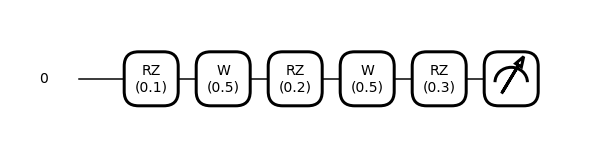

In [2]:
# The QSP circuit would look like this

def QSP_circ(phi, a, wires):

    for angle in phi[:-1]:
        qml.RZ(angle, wires=wires)
        W(a, wires = wires)

    qml.RZ(phi[-1], wires=wires) 
    
    
# This is just to plot it

dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def circuit():
    QSP_circ([0.1,0.2,0.3], 0.5, 0)
    return qml.state()

qml.draw_mpl(circuit, decimals = 1)()

In [3]:
import matplotlib.pyplot as plt

# I define the Hadamard test to calculate real 
# part of the expected value of the circuit.

dev2 = qml.device("default.qubit", wires = 2)

@qml.qnode(dev2)
def expected_value(phi, a):
    qml.Hadamard(wires = 0)
    qml.Hadamard(wires = 1)
    qml.ctrl(QSP_circ, control = 0)(phi, a, wires = 1)
    qml.Hadamard(wires = 0)
    return qml.expval(qml.PauliZ(0))


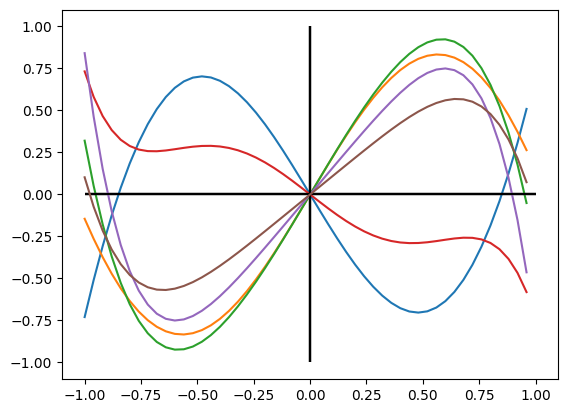

In [4]:
# We run a few examples to see that the properties are fulfilled

d = 5

for _ in range(6):
    
    phi = np.random.rand(d + 1) * 2 * np.pi 

    points = 50
    xs = np.arange(-1,1,2 / points)
    data = [expected_value(phi, x) for x in xs]

    plt.vlines(0.0, -1.0, 1.0, color="black")
    plt.hlines(0.0, -1.0, 1.0, color="black")
    plt.plot(xs, data)

50

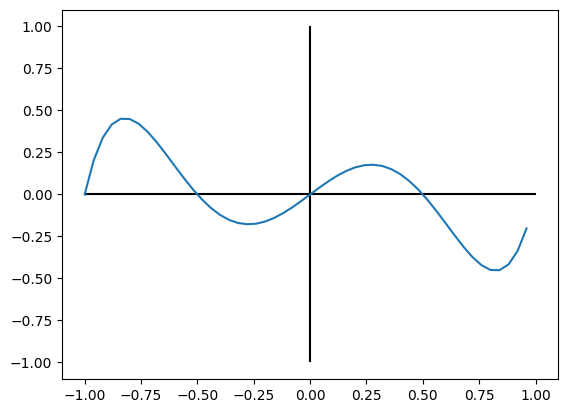

In [5]:
# Let's define the dataset (same of the demo)

dataset = [4 * x**5 - 5 * x**3 + x for x in xs]
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.plot(xs, dataset)

len(dataset)

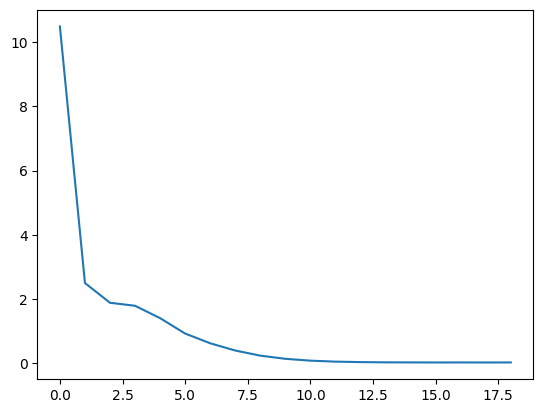

In [6]:
# We define the error function and train 

def error(phi):
    return sum([abs(dataset[i] - expected_value(phi, xs[i])) ** 2 for i in range(points)])


epochs = 20
stepsize = 0.3

d = 9

phi = np.random.rand(d + 1) * 2 * np.pi 
opt = qml.AdagradOptimizer(stepsize)

costs = []
for epoch in range(epochs-1):
    phi, cost = opt.step_and_cost(error, phi)
    costs.append(cost)
    
    
plt.plot(costs)
    

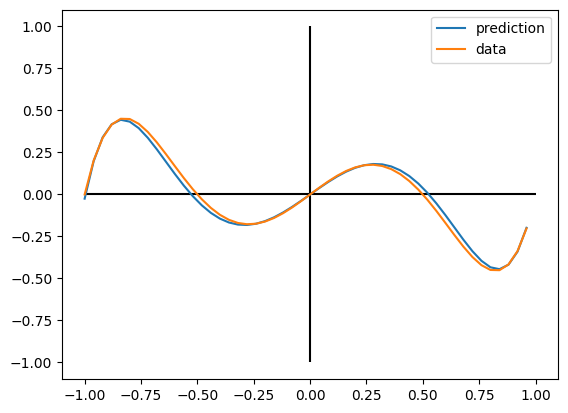

In [7]:
# We plot the final result

preds = [expected_value(phi, xs[i]) for i in range(points)]

plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")

plt.plot(xs, preds, label = "prediction")
plt.plot(xs, dataset, label = "data")
plt.legend()